[Inhalt](./Einleitung.ipynb)

# PointNet-Segmentierungsnetzwerk

Aufbauend auf dem vorherigen Notebook zum PointNet-Klassifizierungsnetzwerk widmet sich dieses Dokument einem praktischen Beispiel für die Segmentierung von 3D-Punktwolken mithilfe von PointNet. Der verwendete Code entstammt einer Implementation von G. Li, zu finden im folgenden Git-Repository: https://github.com/garyli1019/pointnet-keras.

Segmentierung ist eine besondere Form der Klassifizierung, bei der die Elemente eines Objektes spezifischen Teilstücken oder -Bereichen des Gesamtobjekts zugeordnet werden. Ein klassisches Beispiel für Segmente in einem Objekt sind die Beine, Sitzfläche und die Lehne eines Stuhls. Das segmentierte Objekt könnte etwa so aussehen wie in der folgenden Grafik:

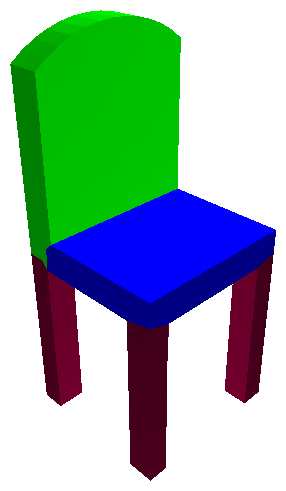
<center>Abbildung 1: Segmente eines Stuhls [1]</center>

Die folgende Grafik von Qi et al. \[1\] zeigt die Architektur von PointNet. Der markierte Bereich stellt hierbei das eigentliche Segmentierungsnetzwerk dar. Wie unschwer zu erkennen ist, wird die Architektur vom Input bis zur Aggregation der globalen Feature-Signatur gleichermaßen vom Klassifikations- und vom Segmentierungsnetzwerk genutzt.

Diese Darstellung wird wie auch im vorherigen Notebook im weiteren Verlauf wiederholt genutzt, um das Durchlaufen der Pipeline zu visualisieren.

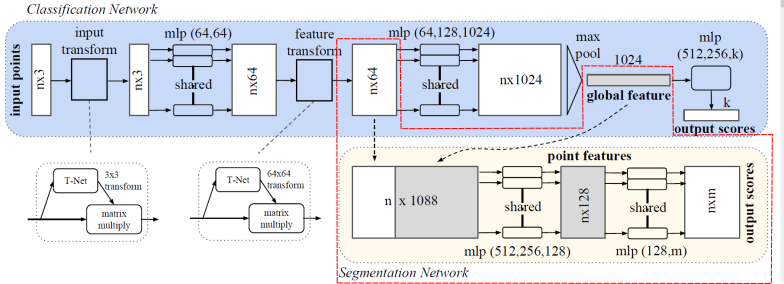
<center>Abbildung 2: PointNet-Segmentierungsnetzwerk [2] </center>


## Anwendungshinweis

Da es sich bei dem Code in diesem Notebook um ein zusammenhängendes Script handelt, empfiehlt sich bei Änderungen stets das Zurücksetzen des Kernels. Hierfür wird unter dem Reiter "Kernel" die Option "Restart & Run all" ausgewählt.

## Imports

Für die hier analyiserte Keras-Implementation der PointNet-Architektur werden drei Pakete benötigt:
* NumPy für die Verwaltung von Datenstrukturen sowie der Handhabung von Vektoren und Matrizen
* H5Py als Schnittstelle für das HDF5-Datenformat
* Tensorflow für die Verwendung der Keras-API, welche Teil des Tensorflow-Cores ist

Darüber hinaus werden die nötigen Keras-Pakete für die Schichttypen und die Erzeugung des Modells importiert.

Für die Darstellung einer segmentierten Punktwolke werden pyplot und Axes3D genutzt.

In [2]:
import warnings
warnings.simplefilter(action='ignore')

%matplotlib notebook

import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Reshape, Dot
from tensorflow.keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Lambda, concatenate
#from keras import optimizers
#from keras.layers import Input
#from keras.models import Model
#from keras.layers import Dense, Reshape
#from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
#from keras.layers import Lambda, concatenate
#from keras.utils import np_utils
import h5py

## Hilfsfunktionen

Nachfolgend werden Hilfsfunktionen definiert. Wie beim Klassifizierungsnetzwerk werden die Funktionen `mat_mul` und `load_5` für die Matrizenmultiplikation und das Laden von HPF5-Files benötigt.

Die Funktion `exp_dim` wird im Modell im Rahmen einer Lambda Layer genutzt, um den globalen Feature-Vektor für die nachfolgende Konkatenation zu erweitern.

In [3]:
def mat_mul(A, B):
    return tf.matmul(A, B)

In [4]:
def exp_dim(global_feature, num_points):
    return tf.tile(global_feature, [1, num_points, 1])

In [5]:
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

Die Funktionen rotate_point_cloud sowie jitter_point_cloud dienen dazu, die Trainingsdaten wiederholt nutzbar zu machen. Durch zufällige Rotationen und Mikro-Translationen der Objekte bzw. Punkte erzeugen die Funktionen aus einem Datensatz eine beliebige Menge unterschiedlicher Trainingsdaten.

rotate_point_cloud erzeugt zunächst eine Nullmatrix mit den Dimensionen des Inputs. Anschließend wird für jedes Objekt eine zufällige Rotationsmatrix erzeugt. Die Produkte der Rotationsmatrix und der Objektpunkte werden in die Nullmatrix eingefügt, welche nach Durchlaufen aller Objekte zurückgegeben wird. Die Rotationsachse ist die Y-Achse.

jitter_point_cloud erzeugt ebenfalls eine Kopie des Inputs. Diese wird jedoch nicht als Nullmatrix initialisiert, sondern mit kleinen Zufallszahlen gefüllt. Anschließend erfolgt eine elementweise Addition mit der Input-Matrix.

In [6]:
def rotate_point_cloud(batch_data):
    """ Randomly rotate the point clouds to augument the dataset
        rotation is per shape based along up direction
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.matmul(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data


In [7]:
def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    """ Randomly jitter points. jittering is per point.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, jittered batch of point clouds
    """
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    jittered_data += batch_data
    return jittered_data

Um das Netzwerk erfolgreich trainieren zu können, muss der Input auf einen Objekttypen wie bspw. Stühle festgelegt werden. Hierfür dient die Variable `s`. Alle verfügbaren Typen sind im Dictionary `sList` in der darauffolgenden Codelzelle zu finden.

In [8]:
# chosen shape
s = 'simple_rect_'

Die folgenden globalen Variablen bestimmen wichtige Randbedingungen der verwendeten Datensätze sowie den verwendenten Optimierungsalgorithmus und sollten daher nicht verändert werden.

In [9]:
# number of points in each sample
num_points = 2048

# shapes and categories
#sList = {'Airplane': 4, 'Chair': 4, 'Guitar': 3, 'Knife': 2, 'Lamp': 3, 'Table': 2}

# number of categories
k = 2
#k = sList[s]
# define optimizer
adam = Adam(lr=0.05)

## Keras-Modell

Wie auch die PointNet-Variante zur Klassifizierung wird das Segmentierungsnetzwerk als Keras-Modell implementiert. Der Aufbau ist vom Input bis zur Aggregation der globalen Feature-Signatur identisch, daher wird im Weiteren nur kurz darauf eingegangen.

Das Hauptaugenmerk liegt auf den letzten Teil des Netzwerks, welcher für die eigentliche Segmentierung genutzt wird.

Zu Beginn des Netzwerks findet die bereits bekannte Input-Transformation statt. Hierbei wird eine Transformationsmatrix bestimmt, mit welcher die Elemente einer eingegebenen Punktwolke räumlich ausgerichtet werden.

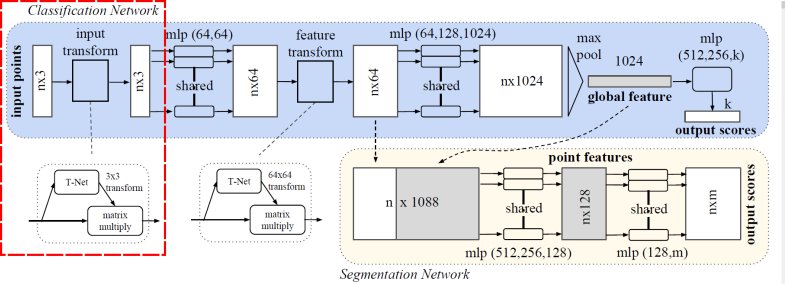
<center>Abbildung 3: Input-Transformation [2] </center>

In [10]:
# ------------------------------------ Pointnet Architecture
# input_Transformation_net
input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu',
                  input_shape=(num_points, 3))(input_points)
x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

Im zweiten Schritt findet das bereits bekannte Feature-Building statt. Zur Erinnerung: Hierbei werden die Raumkoordinaten eines jeden Punktes auf einen höherdimensionalen Raum abgebildet, um vom Netzwerk analysierbare Features zu gewinnen. Diese Form der Abstraktion ermöglicht es, beliebige Punktwolken mit PointNet zu verarbeiten, ohne dass diese vorher in eine spezifische Form konvertiert werden müssen.

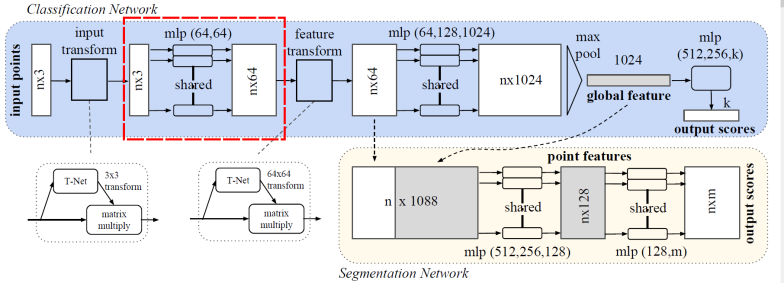
<center>Abbildung 4: Feature Building 1 [2] </center>

In [11]:
# forward net
print('input_T', type(input_T), input_T)
print('input_points', type(input_points), input_points)
# g = tf.keras.layers.Lambda(mat_mul, arguments={'B': input_T})(input_points)
# g = tf.keras.layers.Lambda(tf.matmul, arguments={'b': input_T})(input_points)
g = Dot(axes=(2))([input_points, input_T])
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)

input_T <class 'keras.engine.keras_tensor.KerasTensor'> KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3), dtype=tf.float32, name=None), name='reshape/Reshape:0', description="created by layer 'reshape'")
input_points <class 'keras.engine.keras_tensor.KerasTensor'> KerasTensor(type_spec=TensorSpec(shape=(None, 2048, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


Auch die Feature-Transformation findet in bereits bekannter Weise statt. Die Ausrichtung der Feature-Vektoren im $\mathbb{R}^{64}$ dient ebenso wie die räumliche Ausrichtung im dreidimensionalen Raum dazu, etwaige Transformationen des Inputs wie bspw. Rotationen zu kompensieren.

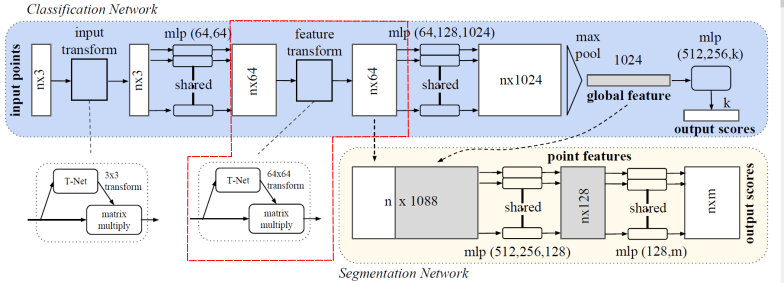
<center>Abbildung 5: Feature-Transformation [2] </center>

In [12]:
# feature transformation net
f = Convolution1D(64, 1, activation='relu')(g)
f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

Im nachfolgenden Schritt findet sich der erste Unterschied zwischen Klassifizierung und Segmentierung. Nach Anwendung der Feature-Transformationsmatrix durch eine Lambda Layer wird der Zwischenstand in der Variablen `seg_part1` zwischengespeichert. Anschließend werden die ausgerichteten Feature-Vektoren über Faltungsschichten auf den $\mathbb{R}^{1024}$ abgebildet.

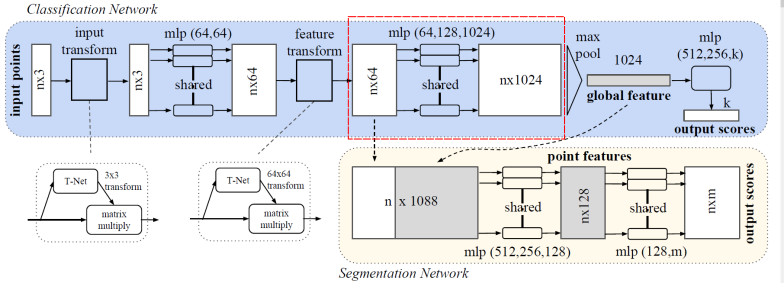
<center>Abbildung 6: Feature Building 2 [2] </center>

In [13]:
# forward net
print(type(g), g)
print(type(feature_T), feature_T)
# g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Dot(axes=(2))([g, feature_T])
seg_part1 = g
g = Convolution1D(64, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
g = BatchNormalization()(g)

<class 'keras.engine.keras_tensor.KerasTensor'> KerasTensor(type_spec=TensorSpec(shape=(None, 2048, 64), dtype=tf.float32, name=None), name='batch_normalization_6/batchnorm/add_1:0', description="created by layer 'batch_normalization_6'")
<class 'keras.engine.keras_tensor.KerasTensor'> KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64), dtype=tf.float32, name=None), name='reshape_1/Reshape:0', description="created by layer 'reshape_1'")


Der durch Max-Pooling aggregierte Feature-Vektor wird über eine Lambda Layer und der eingangs definierten Hilfsfunktion `exp_dim` erweitert. Hierbei werden die 1024 Werte des Vektors für jedes Element einer Punktwolke dupliziert. Im gegebenen Beispiel wird also der Feature-Vektor von 1x1024 auf 1024x1024 erweitert, wobei jede Zeile eine Kopie der globalen Signatur enthält.

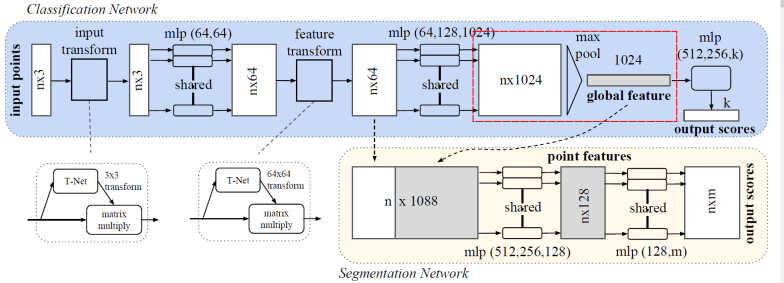
<center>Abbildung 7: Max-Pooling [2] </center>

In [14]:
# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)
global_feature = Lambda(exp_dim, arguments={'num_points': num_points})(global_feature)

Im Anschluss an die Aggregation der globalen Feature-Signatur beginnt das eigentliche Segmentierungsnetzwerk. Im ersten Schritt, welcher in Abbbildung 8 markiert ist, findet eine Konkatenation der zuvor zwischengespeicherten lokalen Features und der globalen Features statt. Durch die nach dem Max-Pooling durchgeführte Erweiterung des globalen Feature-Vektors kann dies ohne Umstände mit der Funktion `concatenate` erreicht werden.

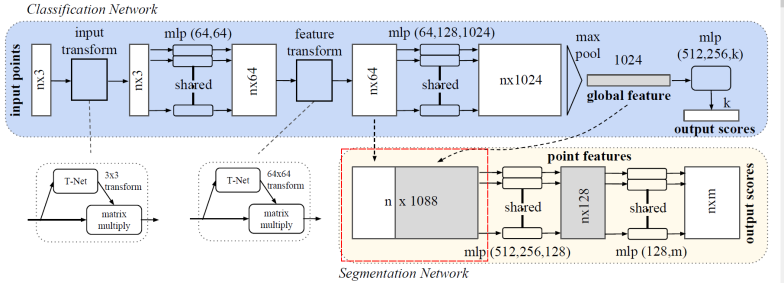
<center>Abbildung 8: Konkatenation lokaler und globaler Features [2] </center>

In [15]:
# point_net_seg
c = concatenate([seg_part1, global_feature])

Mit dem konkatenierten Feature-Vektor wird jedes Element einer Punktwolke durch 1088 Werte beschrieben. Die Kombination von  Informationen über lokale Geometrie und globale Semantik ermöglicht dem Netzwerk, mithilfe eines MLP eine akkurate Vorhersage über die Zugehörigkeit der einzelnen Punkte zu den verfügbaren Objektteilen zu treffen. Dieser Schritt wird in Abbildung 9 markiert dargestellt. Der MLP wird mit insgesamt fünf Faltungsschichten mit Filtern der Größe 1 realisiert. Zwischen den Schichten findet wie gewohnt `batch normalization` statt. Die ersten vier Schichten nutzen ReLU als Aktivierungsfunktion, während die letzte mittels Softmax die finalen Segmentierungswerte für jeden Punkt als Output ermittelt. 

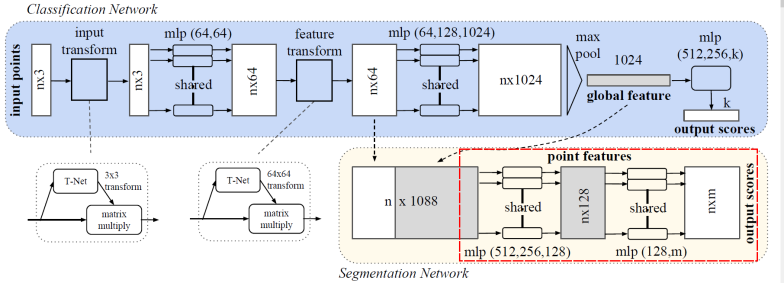
<center>Abbildung 9: Segmentierung [2] </center>

In [16]:
c = Convolution1D(512, 1, activation='relu')(c)
c = BatchNormalization()(c)
c = Convolution1D(256, 1, activation='relu')(c)
c = BatchNormalization()(c)
c = Convolution1D(128, 1, activation='relu')(c)
c = BatchNormalization()(c)
c = Convolution1D(128, 1, activation='relu')(c)
c = BatchNormalization()(c)
prediction = Convolution1D(k, 1, activation='softmax')(c)
# --------------------------------------------------end of pointnet

Wie im vorherigen Notebook wird nach der Vervollständigung des Netzwerks mittels verknüpftem Input und Output das entsprechende Keras-Modell gebildet und dessen Struktur tabellarisch ausgegeben. Anschließend wird das Modell kompiliert, wobei auch in diesem Beispiel der Optimizer `Adam` und die Verlustfunktion `categorical_crossentropy`genutzt werden.

In [17]:
# define model
model = Model(inputs=input_points, outputs=prediction)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2048, 64)     256         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2048, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2048, 128)    8320        batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
# compile classification model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Vorbereitung der Daten

Der Ladeprozess der Trainings- und Testdaten gestaltet sich ähnlich wie im Klassifikationsbeispiel. Die in der globalen Variable `s` festgelegte Objektklasse wird genutzt, um die korrekten HPF5-Files aus den Ordnern "Seg_Prep" bzw. "Seg_Prep_test" auszuwählen. Diese werden anschließend über die Hilfsfunktion `load_h5` eingelesen. Die Daten über Punkte und Labels werden in entsprechend benannte Variablen zwischengespeichert und via `reshape` in die Formen `[Objekt, Punkt, Koordinaten]` bzw. `[Objekt, Punkt, Klasse]` gebracht.

In [19]:
# load TRAIN points and labels
path = os.getcwd()
train_path = os.path.join(path, "Seg_Prep")
filename = s + "train.h5"

train_points = None
train_labels = None
cur_points, cur_labels = load_h5(os.path.join(train_path, filename))

train_labels = cur_labels
train_points = cur_points

train_points_r = train_points.reshape(-1, num_points, 3)
train_labels_r = train_labels.reshape(-1, num_points, k)

In [20]:
# load TEST points and labels
test_path = os.path.join(path, "Seg_Prep_test")
filename = s + "test.h5"

test_points = None
test_labels = None
cur_points, cur_labels = load_h5(os.path.join(test_path, filename))

test_labels = cur_labels
test_points = cur_points

test_points_r = test_points.reshape(-1, num_points, 3)
test_labels_r = test_labels.reshape(-1, num_points, k)

## Trainingsprozess

Das Training des Segmentierungsnetzwerks erfolgt in derselben Weise wie im vorherigen Notebook. Über eine for-Schleife wird eine beliebige Anzahl Iterationen realisiert, in denen die mittels der Funktionen `train_points_rotate` und `train_points_jitter` minimal unterschiedliche Versionen der Trainingsdaten über `model.fit` an das Netzwerk übergeben werden.

Die `batch-size` legt fest, in welchen Chargen die Daten vom Netzwerk verarbeitet bzw. wieviele Elemente pro Update der Gradienten genutzt werden. Darüber hinaus sind bei der `batch normalization` der Bezeichung entsprechend die Elemente einer Charge betroffen.

Der Parameter `epochs` legt die Anzahl der Iterationen fest. Da dies in der übergeordneten Schleife festgelegt ist, um die Trainingsdaten in jeder Iteration zu verändern, liegt der Wert bei 1.

`shuffle` führt dazu, dass die Trainingsdaten vor jeder Epoche in eine zufällige Reihenfolge gebracht werden.

`verbose` legt die Visualisierung fest. Der Wert 1 steht hierbei für die Darstellung eines Fortschrittbalkens.

Wie im vorherigen Notebook findet in jeder fünften Iteration eine Evaluation des Netzwerks mit den Testdaten statt.

In [21]:
# train model
for i in range(21):
    # rotate and jitter point cloud every epoch
    # train_points_rotate = rotate_point_cloud(train_points_r)
    # train_points_jitter = jitter_point_cloud(train_points_r, 10, 20)
    model.fit(train_points_r, train_labels_r, batch_size=128, epochs=1, shuffle=True, verbose=1)
    e = "Current epoch is:" + str(i)
    print(e)
    # evaluate model
    if i % 1 == 0:
        score = model.evaluate(test_points_r, test_labels_r, verbose=1)
        print('Test loss: ', score[0])
        print('Test accuracy: ', score[1])

8/8 [==============================] - 19s 704ms/step - loss: 0.8252 - accuracy: 0.5410
Current epoch is:0
32/32 [==============================] - 2s 42ms/step - loss: 12.0054 - accuracy: 0.0625
Test loss:  12.005449295043945
Test accuracy:  0.06250429153442383
8/8 [==============================] - 6s 706ms/step - loss: 0.6434 - accuracy: 0.6495
Current epoch is:1
32/32 [==============================] - 1s 42ms/step - loss: 1.2835 - accuracy: 0.5035
Test loss:  1.2835456132888794
Test accuracy:  0.5035314559936523
8/8 [==============================] - 6s 708ms/step - loss: 0.5666 - accuracy: 0.7978
Current epoch is:2
32/32 [==============================] - 1s 43ms/step - loss: 0.4496 - accuracy: 0.9160
Test loss:  0.4495847821235657
Test accuracy:  0.916038990020752
8/8 [==============================] - 6s 707ms/step - loss: 0.5104 - accuracy: 0.8866
Current epoch is:3
32/32 [==============================] - 1s 43ms/step - loss: 0.5276 - accuracy: 0.8939
Test loss:  0.5276381969

## Visualisierung

Um die Effektivität des Netzwerks visuell nachvollziehen zu können, wird in den nachfolgenden Code-Zellen ein 3D-Plot eines beliebigen Datensatzes erzeugt.

An dieser Stelle ein wichtiger Hinweis: Um verschiedene Objekte zu visualisieren, muss das Netzwerk nicht jedes Mal von Neuem trainiert werden. Es ist ausreichend, lediglich die nachfolgende Codezelle via "Run"-Befehl auszuführen.

Hierfür wird zunächst ein `figure()`-Objekt des Pakets `matplotlib` erzeugt und mit einem 3D-Subplot gefüllt. Die Achsenbegrenzungen und die Größe der Darstellung können nach Belieben angepasst werden. 

Die Arrays `color` und `m` legen die Farbe und Form der einzelnen Segmente in der Darstellung fest und können ebenfalls nach Belieben angepasst werden. Mögliche Werte können in der Dokumentation von `matplotlib` nachgelesen werden.

Über die Variable `d_num` kann auf die einzelnen Objekte des Testdatensatzes zugegriffen werden. Die entsprechenden Punkte werden extrahiert und an das Netzwerk übergeben. Der Output des Netzwerks wird in der Variable `pred` gespeichert und in eine Liste konvertiert.

Die `squeeze`-Funktion eliminiert atomare Dimensionen, um das Durchlaufen des Datensatzes zu vereinfachen.

Nachdem die Daten ausgewählt und in eine passende Form gebracht wurden, werden die einzelnen Punkte über eine for-Schleife als Scatter-Plot visualisiert.

In [22]:
from open3d import *

# Read .ply file
input_file = "_t.ply"
pcd = open3d.io.read_point_cloud(input_file) # Read the point cloud
pcd = pcd.voxel_down_sample(voxel_size=10.0)
print(pcd.points)

# Convert open3d format to numpy array
# Here, you have the point cloud in numpy format. 
point_cloud_in_numpy = np.asarray(pcd.points)
print(point_cloud_in_numpy.shape)
ch_arr = np.random.choice(len(point_cloud_in_numpy), num_points, replace=False)
print(ch_arr.shape)
point_cloud_in_numpy = point_cloud_in_numpy[ch_arr, :]
print(point_cloud_in_numpy.shape)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
std::vector<Eigen::Vector3d> with 39969 elements.
Use numpy.asarray() to access data.
(39969, 3)
(2048,)
(2048, 3)


<IPython.core.display.Javascript object>


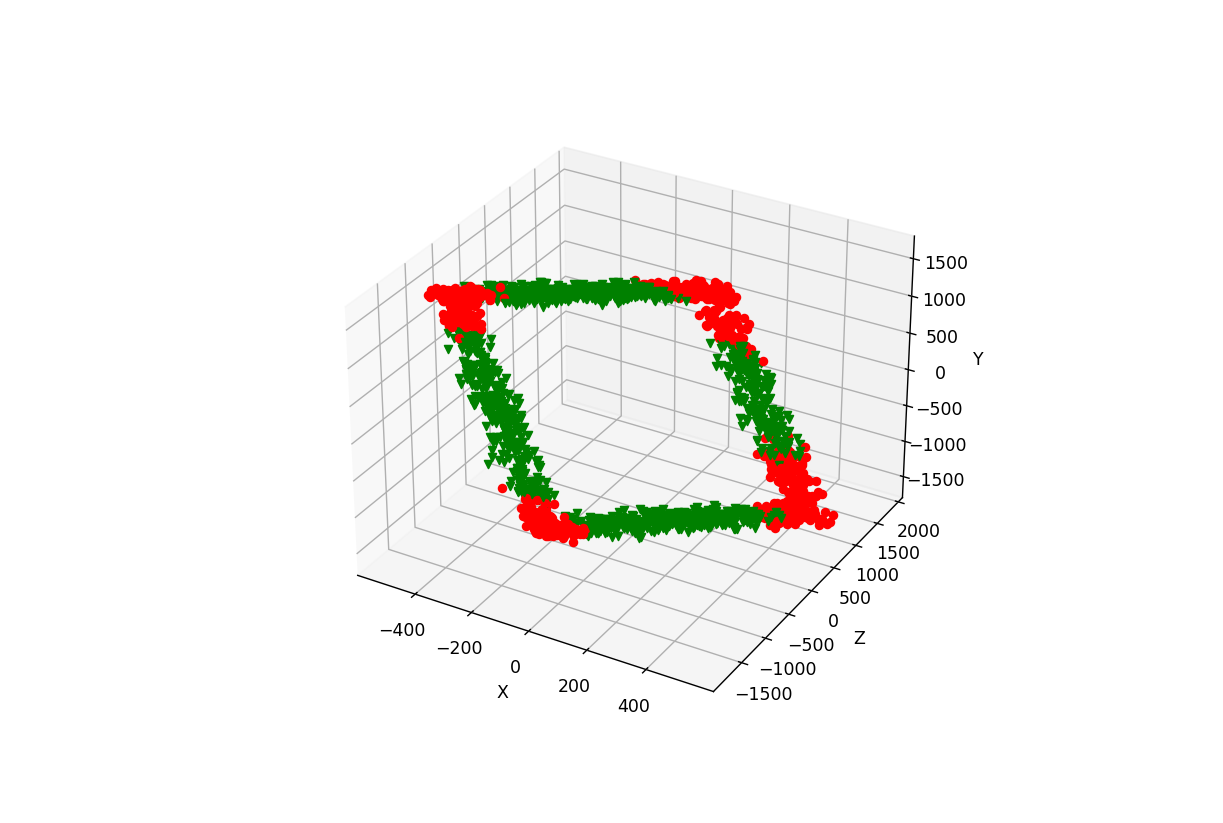

In [24]:
# initialize plot
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

# set marker style and color
color = ['r', 'g', 'c', 'y', 'm']
m= ['o', 'v', '<', '>', 's']

# select test data to visualize
for d_num in range(1):
    v_points = test_points_r[d_num:d_num+1,:,:]
    #v_points = point_cloud_in_numpy[None, :, :]
    #print('v_points.shape: ', v_points[0].shape)
    #pcd = open3d.geometry.PointCloud()
    #pcd.points = open3d.utility.Vector3dVector(v_points[0])
    #open3d.io.write_point_cloud("./data.ply", pcd)
    
    #print(v_points.shape)

    pred = model.predict(v_points)
    pred = np.squeeze(pred)
    v_points = np.squeeze(v_points)
    pred = pred.tolist()

    # add data to plot
    for i in range(v_points.shape[0]):
        xs = v_points[i,0]
        ys = v_points[i,1]
        zs = v_points[i,2]
        ind = pred[i].index(max(pred[i]))
        ax.scatter(xs, zs, ys, c=color[ind], marker=m[ind])

    # set axis labels and limits
    #ax.set_xlim3d(-3100,3100)
    #ax.set_ylim3d(-3100,3100)
    #ax.set_zlim3d(-3100,3100)

    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')   

    plt.show()
    #plt.savefig('test_50_epochs/plot_50_epochs.' + str(d_num) + '.pdf')
    #plt.cla()
    #print('d_num:', d_num)

Quellen: 

\[1\] L. Yi et al., “A Scalable Active Framework for Region Annotation in 3D Shape Collections,” SIGGRAPH Asia, 2016. [Online]. Available: http://web.stanford.edu/~ericyi/project_page/part_annotation/index.html

\[2\] C. R. Qi, H. Su, K. Mo, and L. J. Guibas, “PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation,” CoRR, vol. abs/1612.00593, 2016, [Online]. Available: http://arxiv.org/abs/1612.00593.